# Data 612 - Assignment 2 
### Michael D'Acampora

The goal of this assignment is to try out different ways of implementing and configuring a recommender, and to evaluate the different approaches. The first method will be to implement a rudimentary item-item based collaborative filtering algorithm. The algorithm would recommend the movies with the highest correlated ratings to the subject movie. 



## Method 1 - Simple Collaborative Filtering

Data was obtained from the movieLens repository https://grouplens.org/datasets/movielens/. 

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
ratings = pd.read_csv('https://raw.githubusercontent.com/mjdacs/data612/master/project_2/ml-latest-small/ratings.csv')
movies = pd.read_csv('https://raw.githubusercontent.com/mjdacs/data612/master/project_2/ml-latest-small/movies.csv', index_col='movieId')
tags = pd.read_csv('https://raw.githubusercontent.com/mjdacs/data612/master/project_2/ml-latest-small/tags.csv')

# ratings = pd.read_csv('C:\\Users\\1239783\\Python\\data612-master\\project_2\\ml-latest-small\\ratings.csv')
# movies = pd.read_csv('C:\\Users\\1239783\\Python\\data612-master\\project_2\\ml-latest-small\\movies.csv', index_col='movieId')
# tags = pd.read_csv('C:\\Users\\1239783\\Python\\data612-master\\project_2\\ml-latest-small\\tags.csv')

URLError: <urlopen error [WinError 10054] An existing connection was forcibly closed by the remote host>

In [312]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [313]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [314]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [315]:
# links.head()

In [316]:
print(ratings.shape, movies.shape, tags.shape)

(100836, 4) (9742, 2) (3683, 4)


After taking a look, it seems like movies and ratings datasets are the ones to merge for this project. Afterwards we take a look at some statisticals descriptors.

In [317]:
df = pd.merge(ratings, movies, on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [318]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Since there are a multitude of rows with the same title, it is best we group them together to obtain an average rating and to provide the total number of ratings for each, and display sorted by number of ratings in descending order.

In [319]:
avg_ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
avg_ratings.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


In [320]:
avg_ratings['n_ratings']= df.groupby('title')['rating'].count()
avg_ratings.sort_values(by='n_ratings',ascending=False).head()

,rating,n_ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278


Looking at the plots below, most ratings fall on the round numbers (and halves), but we can see most of the ratings fall between about 2.75 and 4.25.

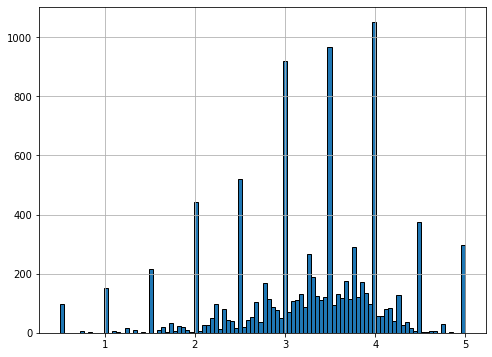

In [321]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
avg_ratings['rating'].hist(bins=100)

Additionally we can get a clue as to how sparse this matrix could become, seeing that a vast majority of movies have a single digit number of ratings.

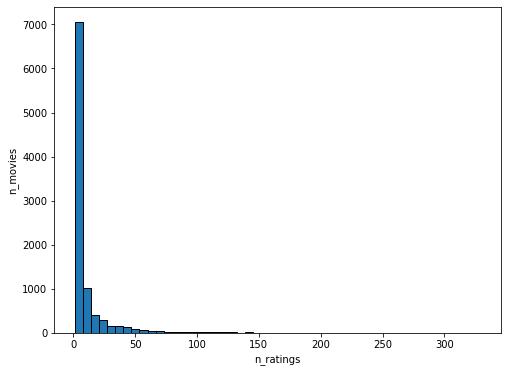

In [322]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
plt.hist(avg_ratings['n_ratings'], bins=50)
# avg_ratings['n_ratings'].hist(bins=50)
plt.xlabel("n_ratings")
plt.ylabel("n_movies")
plt.show()

We can see in the scatterplot below that there does appear to be some positive relationship between the number of ratings a movie gets and its actual rating. 

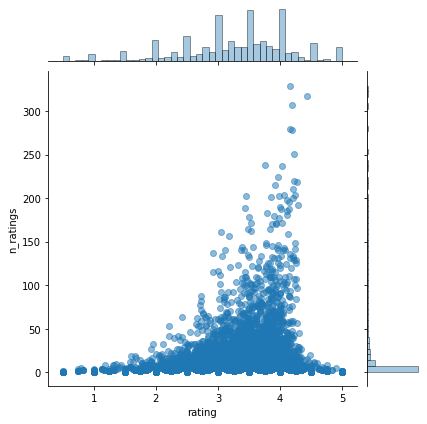

In [323]:
sns.jointplot(x='rating', y='n_ratings', data=avg_ratings, alpha=0.5)

Now we have to create the user-item matrix which is a table of every movie in the database and the ratings by each and every user. Since each user will not rate anything close to all the movies in the database, we will have a very sparse matrix like mentioned in the plot section.

In [324]:
movie_matrix = df.pivot_table(index='userId', columns='title', values='rating')
movie_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [325]:
movie_matrix.shape

(610, 9719)

### The next step
Let's pick a couple of movies and run correlations on them. This will be the our outcomes for recommendations. Pulp Fiction and The Matrix are the chosen titles. The next two code blocks pull the column values and assign to a new variable.

In [326]:
pulpfiction_user_rating = movie_matrix['Pulp Fiction (1994)']
pulpfiction_user_rating.head(10)


userId
1     3.0
2     NaN
3     NaN
4     1.0
5     5.0
6     2.0
7     NaN
8     4.0
9     NaN
10    1.0
Name: Pulp Fiction (1994), dtype: float64

In [327]:
thematrix_user_rating = movie_matrix['Matrix, The (1999)']
thematrix_user_rating.head(10)

userId
1     5.0
2     NaN
3     NaN
4     1.0
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    0.5
Name: Matrix, The (1999), dtype: float64

Now we obtain a list of movies correlated to Pulp Fiction and The Matrix, respectively:

In [328]:
corr_w_pulpfiction = movie_matrix.corrwith(pulpfiction_user_rating)
corr_w_pulpfiction.head(10)

title
'71 (2014)                                      NaN
'Hellboy': The Seeds of Creation (2004)         NaN
'Round Midnight (1986)                          NaN
'Salem's Lot (2004)                             NaN
'Til There Was You (1997)                       NaN
'Tis the Season for Love (2015)                 NaN
'burbs, The (1989)                        -0.187323
'night Mother (1986)                            NaN
(500) Days of Summer (2009)               -0.044034
*batteries not included (1987)            -0.738549
dtype: float64

In [329]:
corr_w_thematrix = movie_matrix.corrwith(thematrix_user_rating)
corr_w_thematrix.head(10)

title
'71 (2014)                                      NaN
'Hellboy': The Seeds of Creation (2004)         NaN
'Round Midnight (1986)                          NaN
'Salem's Lot (2004)                             NaN
'Til There Was You (1997)                       NaN
'Tis the Season for Love (2015)                 NaN
'burbs, The (1989)                        -0.160843
'night Mother (1986)                            NaN
(500) Days of Summer (2009)                0.302316
*batteries not included (1987)             0.392232
dtype: float64

There are a bunch of NaN's, so we clean that up by dropping them for both movie correlation sets.

In [330]:
corr_w_pulpfiction = pd.DataFrame(corr_w_pulpfiction, columns=['Correlation'])
corr_w_pulpfiction.dropna(inplace=True)
corr_w_pulpfiction.head()

,Correlation
title,
"'burbs, The (1989)",-0.187323
(500) Days of Summer (2009),-0.044034
*batteries not included (1987),-0.738549
...And Justice for All (1979),-0.188982
10 Cent Pistol (2015),1.000000


In [331]:
corr_w_thematrix = pd.DataFrame(corr_w_thematrix, columns=['Correlation'])
corr_w_thematrix.dropna(inplace=True)
corr_w_thematrix.head()

,Correlation
title,
"'burbs, The (1989)",-0.160843
(500) Days of Summer (2009),0.302316
*batteries not included (1987),0.392232
...And Justice for All (1979),0.654654
10 Cent Pistol (2015),-1.000000


#### Afterwards 
We join the number of ratings for each movie back to the dataframe. Since we saw in the plots above that most movies had less than ten ratings, we will look to drop rows below a certain threshold. In our case we will only keep movies with more than 100 ratings. The sorted top 10 will be our recommendations.

In [332]:
corr_w_pulpfiction = corr_w_pulpfiction.join(avg_ratings['n_ratings'])
corr_w_thematrix = corr_w_thematrix.join(avg_ratings['n_ratings'])

In [333]:
corr_w_pulpfiction.head()

,Correlation,n_ratings
title,,
"'burbs, The (1989)",-0.187323,17
(500) Days of Summer (2009),-0.044034,42
*batteries not included (1987),-0.738549,7
...And Justice for All (1979),-0.188982,3
10 Cent Pistol (2015),1.000000,2


In [334]:
corr_w_thematrix.head()

,Correlation,n_ratings
title,,
"'burbs, The (1989)",-0.160843,17
(500) Days of Summer (2009),0.302316,42
*batteries not included (1987),0.392232,7
...And Justice for All (1979),0.654654,3
10 Cent Pistol (2015),-1.000000,2


#### The results are in...
Below are the top 10 most correlated movies for each Pulp Fiction and The Matrix. This is a simple recommender system that is bare bones and not ready for production.

In [335]:
corr_w_pulpfiction[corr_w_pulpfiction['n_ratings'] > 100].sort_values(by='Correlation', ascending=False).head(11)

,Correlation,n_ratings
title,,
Pulp Fiction (1994),1.000000,307
Fight Club (1999),0.543465,218
Kill Bill: Vol. 1 (2003),0.504147,131
Trainspotting (1996),0.437714,102
Kill Bill: Vol. 2 (2004),0.421685,110
"Usual Suspects, The (1995)",0.411700,204
"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",0.402193,120
Eternal Sunshine of the Spotless Mind (2004),0.401534,131
Reservoir Dogs (1992),0.394687,131


In [336]:
corr_w_thematrix[corr_w_thematrix['n_ratings'] > 100].sort_values(by='Correlation', ascending=False).head(11)

,Correlation,n_ratings
title,,
"Matrix, The (1999)",1.000000,278
Die Hard (1988),0.544466,145
Inception (2010),0.514767,143
Braveheart (1995),0.496045,237
Aliens (1986),0.470865,126
"Lion King, The (1994)",0.444932,172
"Monsters, Inc. (2001)",0.441205,132
Batman Begins (2005),0.440338,116
Jurassic Park (1993),0.427936,238


### Final words on Method 1:
It is an easy to use approach since no training or optimization is involved. But its performance decreases as the more sparse the data becomes which limits this approach for most real-world problems. Additionally there is more information we can glean other than user rating to make better recommendations, which we'll see in method 2.

## Method 2 - Attribute based item-item collaborative filtering approach

We can add a little more to the recommender we created in Method 1. This time we can take into account other attributes, like genre, director, actors, and MPAA rating. This is done by downloading OMBD ratings which contain these attributes.

In [4]:

ombd = pd.read_csv("https://raw.githubusercontent.com/mjdacs/data612/master/project_2/movieInfo.csv?_sm_au_=iVVkQjrFW41HQtHN", index_col=0)
#ombd = pd.read_csv("C:\\Users\\1239783\\Python\\data612-master\\project_2\\movieInfo.csv", index_col=0)
ombd.head()

URLError: <urlopen error [WinError 10054] An existing connection was forcibly closed by the remote host>

In [338]:
ombd.shape

(1792, 7)

Looking at the NA values, we can see that there exists one plot value without an entry, which we will drop.

In [339]:
ombd.isna().sum()

plot            1
director        0
actors          0
rated          42
genre           0
imdb_rating     0
title           0
dtype: int64

In [340]:
ombd = ombd[pd.notnull(ombd['plot'])]
ombd.isna().sum()

plot            0
director        0
actors          0
rated          41
genre           0
imdb_rating     0
title           0
dtype: int64

In [341]:
ombd_df = ombd.drop(['plot', 'imdb_rating'], axis=1)
ombd_df

,director,actors,rated,genre,title
1,John Lasseter,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney",G,"Animation, Adventure, Comedy",Toy Story
2,Joe Johnston,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",PG,"Adventure, Family, Fantasy",Jumanji
3,Howard Deutch,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",PG-13,"Comedy, Romance",Grumpier Old Men
4,Forest Whitaker,"Whitney Houston, Angela Bassett, Loretta Devin...",R,"Comedy, Drama, Romance",Waiting to Exhale
5,Charles Shyer,"Steve Martin, Diane Keaton, Martin Short, Kimb...",PG,"Comedy, Family, Romance",Father of the Bride Part II
6,Michael Mann,"Al Pacino, Robert De Niro, Val Kilmer, Jon Voight",R,"Crime, Drama, Thriller",Heat
7,Sydney Pollack,"Harrison Ford, Julia Ormond, Greg Kinnear, Nan...",PG,"Comedy, Drama",Sabrina
8,Peter Hewitt,"Jonathan Taylor Thomas, Brad Renfro, Eric Schw...",PG,"Adventure, Comedy, Drama",Tom and Huck
9,Peter Hyams,"Jean-Claude Van Damme, Powers Boothe, Raymond ...",R,"Action, Crime, Thriller",Sudden Death
10,Martin Campbell,"Pierce Brosnan, Sean Bean, Izabella Scorupco, ...",PG-13,"Action, Adventure, Thriller",GoldenEye


To take Method 1 a step further we will calculate Euclidean distances on our attributes. In order to separate the attributes for this formulation we will create a dummy matrix that takes the director, MPAA rating, genre, and actors columns.

In [342]:
dumDirector = pd.get_dummies(ombd_df['director'])
dumRated = pd.get_dummies(ombd_df['rated'])
dumGenre = ombd_df['genre'].str.get_dummies(sep=',')
dumActors = ombd_df['actors'].str.get_dummies(sep=',')

In [343]:
distance_df = pd.concat([dumDirector, dumRated, dumGenre, dumActors], axis=1)
distance_df.head()

,Aaron Speiser,Abbas Kiarostami,Abel Ferrara,Abraham Polonsky,Adam Resnick,Adrian Lyne,Agnieszka Holland,Akira Kurosawa,Al Pacino,Alain Berliner,...,Ying Huang,You Ge,Yun-Fat Chow,Yves Montand,Yûki Kudô,Zach Galligan,Zbigniew Zamachowski,Zdenek Sverák,Élodie Bouchez,Émile Genest
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [344]:
euc_distance = euclidean_distances(distance_df, distance_df)

In [345]:
distance_df = pd.DataFrame(euc_distance)
distance_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790
0,0.000000,4.242641,4.123106,4.242641,4.242641,4.242641,4.123106,4.000000,4.242641,4.000000,...,4.242641,4.242641,4.242641,3.741657,4.123106,4.242641,4.000000,4.242641,4.242641,4.000000
1,4.242641,0.000000,4.123106,4.242641,3.741657,4.242641,3.872983,3.741657,4.242641,4.242641,...,4.242641,4.242641,3.741657,4.000000,4.123106,4.242641,3.741657,4.000000,3.162278,3.741657
2,4.123106,4.123106,0.000000,3.605551,3.605551,4.123106,3.741657,4.123106,4.123106,3.872983,...,3.872983,4.123106,3.872983,4.123106,3.741657,3.872983,3.872983,3.872983,4.123106,4.123106
3,4.242641,4.242641,3.605551,0.000000,3.741657,3.741657,3.605551,4.000000,4.000000,4.242641,...,3.464102,3.741657,3.741657,4.000000,3.316625,3.464102,4.000000,3.741657,4.242641,4.242641
4,4.242641,3.741657,3.605551,3.741657,0.000000,4.242641,3.605551,4.000000,4.242641,4.242641,...,4.000000,4.242641,3.464102,4.000000,3.872983,4.000000,3.741657,3.741657,3.741657,4.000000


In [346]:
distance_df.columns = ombd_df.index
distance_df.index = ombd_df.index
distance_df.head()

,1,2,3,4,5,6,7,8,9,10,...,2390,2391,2392,2394,2395,2396,2397,2398,2399,2400
1,0.000000,4.242641,4.123106,4.242641,4.242641,4.242641,4.123106,4.000000,4.242641,4.000000,...,4.242641,4.242641,4.242641,3.741657,4.123106,4.242641,4.000000,4.242641,4.242641,4.000000
2,4.242641,0.000000,4.123106,4.242641,3.741657,4.242641,3.872983,3.741657,4.242641,4.242641,...,4.242641,4.242641,3.741657,4.000000,4.123106,4.242641,3.741657,4.000000,3.162278,3.741657
3,4.123106,4.123106,0.000000,3.605551,3.605551,4.123106,3.741657,4.123106,4.123106,3.872983,...,3.872983,4.123106,3.872983,4.123106,3.741657,3.872983,3.872983,3.872983,4.123106,4.123106
4,4.242641,4.242641,3.605551,0.000000,3.741657,3.741657,3.605551,4.000000,4.000000,4.242641,...,3.464102,3.741657,3.741657,4.000000,3.316625,3.464102,4.000000,3.741657,4.242641,4.242641
5,4.242641,3.741657,3.605551,3.741657,0.000000,4.242641,3.605551,4.000000,4.242641,4.242641,...,4.000000,4.242641,3.464102,4.000000,3.872983,4.000000,3.741657,3.741657,3.741657,4.000000


We can create a function that takes and index value and returns the movie along with its top 10 recommendations:

In [347]:
def recommend_movies(movieIndex=1):
    recommendation = distance_df.loc[movieIndex,:].sort_values(ascending=True)[1:11].index 
    print(f"Top 10 Recommendations for a movie like {ombd['title'][movieIndex]}:")
    return ombd.loc[recommendation,['title', 'plot']]

In [348]:
recommend_movies(1)

Top 10 Recommendations for a movie like Toy Story:


,title,plot
239,A Goofy Movie,When Max makes a preposterous promise to a gir...
2141,An American Tail,"While emigrating to the United States, a young..."
709,Oliver & Company,A lost and alone kitten joins a gang of dogs e...
1566,Hercules,The son of the Greek Gods Zeus and Hera is str...
588,Aladdin,When a street urchin vies for the love of a be...
2102,Steamboat Willie,"Mickey Mouse, piloting a steamboat, delights h..."
1881,The Magic Sword: Quest for Camelot,"An adventurous girl, a young blind hermit, and..."
1025,The Sword in the Stone,A poor boy named Arthur learns the power of lo...
2355,A Bug's Life,"A misfit ant, looking for ""warriors"" to save h..."
1030,Pete's Dragon,An orphan boy and his magical dragon come to t...


In [349]:
recommend_movies(1544)

Top 10 Recommendations for a movie like The Lost World: Jurassic Park:


,title,plot
1527,The Fifth Element,"In the colorful future, a cab driver unwitting..."
2021,Dune,A Duke's son leads desert warriors against the...
653,DragonHeart,The last dragon and a disillusioned dragonslay...
316,Stargate,"An interstellar teleportation device, found in..."
1917,Armageddon,After discovering that an asteroid the size of...
2153,The Avengers,Two British agents team up to stop Sir August ...
1291,Indiana Jones and the Last Crusade,"When Dr. Henry Jones, Sr. suddenly goes missin..."
208,Waterworld,In a future where the polar ice-caps have melt...
2368,King Kong Lives,Kong falls from the twin towers and he appears...
2115,Indiana Jones and the Temple of Doom,"After arriving in India, Indiana Jones is aske..."


### Conclusion for Method 2:

I was having trouble resetting the index of the dataset. While the index ended at 2400, it was only 1792 rows long. Resetting the index looked good at first but wound up recommending some NaN values in the Top 10. Overall, this list seems more accurate than the simple model, and a bit more accurate when splitting up the genre tags and actor tags to include all the possibilites.
